# EXAMPLE: 
# USING coralign.pupilfit.pupilfit.fit_unmasked_pupil() FOR ALIGNMENT

### IMPORTS

In [1]:
import sys
import os
sys.path.insert(0,"../")
sys.path.append("/opt/homebrew/lib/python3.10/site-packages")

import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt
from astropy.io import fits

from coralign.pupil import pupilfit
from coralign.util import shapes, mft
from coralign.util.loadyaml import loadyaml

from tempfile import NamedTemporaryFile

### FUNCTIONS FOR GENERATION OF SIMULATED PUPIL PLANE

In [2]:
def gen_pupil(pupil_x_shear, pupil_y_shear, print_figure=False):
    # %% Pupil Generation

    Nbeam = 100
    nx = 150
    ny = nx
    xOffset = pupil_x_shear
    yOffset = pupil_y_shear
    diamInner = 0.20*Nbeam
    diamOuter = 1.00*Nbeam
    strutAngles = np.array([0, 90, 180, 270]) + 15
    strutWidth = 0.03*Nbeam
    pupil = shapes.simple_pupil(nx, ny, xOffset, yOffset, diamInner, diamOuter,
                                strutAngles=strutAngles, strutWidth=strutWidth)

    if print_figure:
        plt.figure(1)
        plt.imshow(pupil)
        plt.colorbar()
        plt.gca().invert_yaxis()
        plt.title("PUPIL")
        plt.pause(0.1)
        
    return pupil

In [3]:
# %% Apply noise to the images

def add_pupil_noise(pupil, image_noise_factor, print_figure=False):
    
    IpupilNoisy = pupil + image_noise_factor*np.random.randn(pupil.shape[0], pupil.shape[1])
    
    if print_figure:
        plt.figure(2)
        plt.imshow(IpupilNoisy)
        plt.colorbar()
        plt.gca().invert_yaxis()
        plt.title('PUPIL WITH NOISE')
        plt.pause(0.1)
        
    return IpupilNoisy

### EXAMPLE OF FUNCTION TO PERFORM PUPIL ALIGNMENT 

In [4]:
def simulate_fit_unmasked_pupil_alignment(pupil_x_shear, pupil_y_shear, image_noise_factor, const, print_figure=False):
        
    pupil_x_center_true = 0
    pupil_y_center_true = 0
    
    pupil = gen_pupil(pupil_x_shear, pupil_y_shear)
    noisy_pupil = add_pupil_noise(pupil, image_noise_factor, print_figure)
    computed_pupil = noisy_pupil
    
    xOffset, yOffset = float("inf"), float("inf")
    iterations = 0
    
    while ((abs(pupil_x_center_true - pupil_x_shear) > 1/8 or abs(pupil_y_center_true - pupil_y_shear) > 1/8) and iterations < 20):

        fn_tuning = "testdata/ut_fit_unmasked_pupil.yaml"
        fn_pupil_ellipse_fitting = "testdata/ut_fit_pupil_as_ellipse_diam_michael.yaml"

        tuning_dict = loadyaml(fn_tuning)
        fnMaskRefHighRes = tuning_dict['fnMaskRefHighRes']
        diamHighRes = tuning_dict['diamHighRes']
        
        nArray = int(diamHighRes + 50)
        pupilHighRes = shapes.ellipse(nArray, nArray,
                                    0.5*diamHighRes*0.9901, 0.5*diamHighRes,
                                    0, 0, 0) -\
                    shapes.ellipse(nArray, nArray,
                                    0.05*diamHighRes, 0.3*diamHighRes,
                                    0, 0, 0)

        # Refer to https://echorand.me/posts/named_temporary_file/ for help
        # with the temporary file usage.
        f = NamedTemporaryFile()
        # Save original name (the "name" actually is the absolute path)
        original_path = f.name
        f.name = fnMaskRefHighRes
        hdu = fits.PrimaryHDU(pupilHighRes)
        hdu.writeto(f.name, overwrite=True)
        
        xOffset, yOffset, clockEst, diamEst = pupilfit.fit_unmasked_pupil(computed_pupil, fn_tuning, fn_pupil_ellipse_fitting, './')
        
        os.unlink(f.name)
        
        pupil_x_shear -= xOffset * const
        pupil_y_shear -= yOffset * const
        
        computed_pupil = gen_pupil(pupil_x_shear, pupil_y_shear)
        
        computed_pupil = add_pupil_noise(computed_pupil,image_noise_factor, print_figure)

        iterations += 1
    
    return iterations

### EXAMPLE OF FUNCTION TO OPTIMIZE CONSTANT FOR PUPIL ALIGNMENT

In [5]:
def find_optimal_const(pupil_x_shear, pupil_y_shear, image_noise_factor, range_limit, print_figure=False, print_iteration_num=False):
    min_num_iterations = float("inf")
    optimal_const = -1
    const = 0.85
    
    while const < range_limit:
    
        num_iterations = simulate_fit_unmasked_pupil_alignment(pupil_x_shear, pupil_y_shear, image_noise_factor, const)
        
        if(print_iteration_num):
            print("CONSTANT" , const, "TOOK", num_iterations, "ITERATIONS TO CONVERGE.")
        
        if num_iterations < min_num_iterations:
            min_num_iterations = num_iterations
            optimal_const = const
        
        const += 0.05
        
    return optimal_const, min_num_iterations

### MODIFIABLE PARAMETERS

In [6]:
# PUPIL
pupil_x_shear = -7  # in units of pixels
pupil_y_shear = 5  # in units of pixels

# NOISE FACTOR
image_noise_factor = 0.08

# CONSTANT
optimization_range_limit = 1.25

### GENERATE PUPIL (SIMULATION)

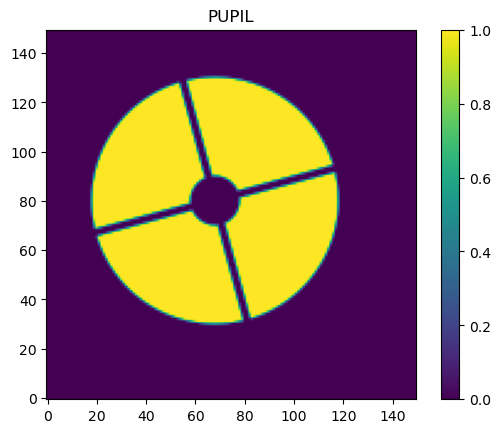

In [7]:
pupil = gen_pupil(pupil_x_shear, pupil_y_shear, True)

### OPTIMIZE CONSTANT VALUE FOR PUPIL ALIGNMENT

In [8]:
optimal_const, min_num_iterations = find_optimal_const(pupil_x_shear, pupil_y_shear, image_noise_factor, optimization_range_limit, print_iteration_num = True)
min_num_it_str = "(" + str(min_num_iterations) + " ITERATION(S))"
print("OPTIMAL CONSTANT:", optimal_const, min_num_it_str)

CONSTANT 0.85 TOOK 3 ITERATIONS TO CONVERGE.
CONSTANT 0.9 TOOK 2 ITERATIONS TO CONVERGE.
CONSTANT 0.9500000000000001 TOOK 2 ITERATIONS TO CONVERGE.
CONSTANT 1.0 TOOK 1 ITERATIONS TO CONVERGE.
CONSTANT 1.05 TOOK 2 ITERATIONS TO CONVERGE.
CONSTANT 1.1 TOOK 2 ITERATIONS TO CONVERGE.
CONSTANT 1.1500000000000001 TOOK 2 ITERATIONS TO CONVERGE.
CONSTANT 1.2000000000000002 TOOK 3 ITERATIONS TO CONVERGE.
OPTIMAL CONSTANT: 1.0 (1 ITERATION(S))


### SIMULATE ALIGNMENT OF PUPIL

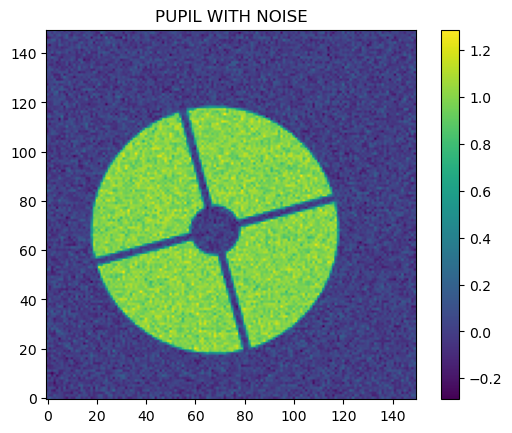

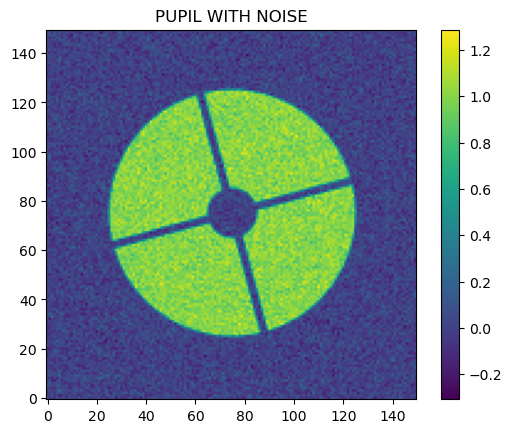

ITERATIONS UNTIL CONVERGENCE: 1


In [9]:
num_iterations = simulate_fit_unmasked_pupil_alignment(pupil_x_shear, pupil_x_shear, image_noise_factor, optimal_const, True)
print("ITERATIONS UNTIL CONVERGENCE:", num_iterations)